# Balancing Builds in Oxygen Not Included

One of the aspects I find most engaging about [Oxygen Not Included](https://www.klei.com/games/oxygen-not-included)
is the challenge of assembling balanced systems -- sets of machines that consume and produce resources at sustainable levels. This can be surprisingly subtle, with systems that *look* sustainable for hours of gameplay, but which slowly leak heat or leach non-sustainable resources. Having these problems creep up on you is a strange combination of fun and infuriating. 

The `oni` python library keeps track of the resources produced and consumed by various machines, and can compute what systems look like in **steady state**, where inputs and outputs are balanced. 

Because why shouldn't playing a videogame feel like doing your taxes?

Run or edit a live version of this notebook at Binder

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ChrisBeaumont/oni/master?filepath=doc%2FONI%20Guide.ipynb)

# Machines and Resources 

### Let's build a lightbulb

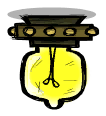


In [1]:
from oni import *

In [2]:
light = CeilingLight()

The `oni` library has a big collection of **machines** and **resources**. `CeilingLight` is a machine -- the key feature of a machine is that it needs and gives resources:

In [3]:
light.needs()

{Power: 10}

In [4]:
light.gives()

{Heat: 500}

`Power` and `Heat` are resources. To run 100% of the time, a light needs 10 units of power every second (Watts), and produces 500 units (DTUs) of heat. While it also has other effects (like, it lights stuff up), we'll only focus on
the consumable resources that flow in and out of machines. 

Note that *anything* that needs and gives resources is considered a machine -- this includes things like Duplicants (needs Oxygen and Food, gives CO2), Critters, and Plants.

We can combine several machines together to build a `System`. Let's plug our lightbulb into a manual generator:

In [5]:
system = CeilingLight() + ManualGenerator()

A system also gives and needs resources, equal to the sum of its machines:

In [6]:
system.needs()

{Power: 10}

In [7]:
system.gives()

{Heat: 1500, Power: 400}

Note that our system gives more power than it needs, meaning we don't need to run our generator full-time to keep the lights on. The `balance` method is our workhorse for thinking through scenarios like this. By default, `balance` will  run each machine as much as it can, as long as the system gives at least as much as it needs:

In [8]:
system.balance()
print(system)

[0] CeilingLight [100.0% Uptime]
[1] ManualGenerator [100.0% Uptime]


In [9]:
system.net_output()

OrderedDict([(Heat, 1500.0), (Power, 390.0)])

Running both machines at 100% capacity leads to an excess 390W of power, and 1500 DTU/s of heat. Alternatively, we can tell `balance` to neutralize certain resources, which will scale systems to prevent over-production of that resource. For example, we only need to run the generator 2.5% of the time to generate all of our power needs (assuming we store that energy for later consumption, say in a battery):

In [10]:
print(system.balance(neutralize=Power))

[0] CeilingLight [100.0% Uptime]
[1] ManualGenerator [2.5% Uptime]


In [11]:
system.net_output()

OrderedDict([(Heat, 525.0)])

We'll run into a problem if we try to neutralize heat as well -- none of our machines consume heat, so the only neutral system is one which never runs!

In [12]:
print(system.balance(neutralize=[Power, Heat]))

[0] CeilingLight [0.0% Uptime]
[1] ManualGenerator [0.0% Uptime]


We can fix this by adding a heat deletion machine -- say a WheezeWort:

In [13]:
print((system + WheezeWort()).balance(neutralize=[Heat, Power]))

[0] CeilingLight [100.0% Uptime]
[1] ManualGenerator [2.5% Uptime]
[2] WheezeWort [0.4% Uptime]


Or a catch-all "Sink" (which isn't a real machine in the game, but just something you can use for bookkeeping)

In [14]:
print((system + Sink(Heat, 700)).balance(neutralize='all'))  # 'all' will balance every resource of the system

[0] CeilingLight [100.0% Uptime]
[1] ManualGenerator [2.5% Uptime]
[2] Sink(Heat, 700) [75.0% Uptime]


Note that, if your system needs more than it gives of some resource, your machines will be throttled even without neutralizing anything:

In [15]:
too_many_lights = 50 * CeilingLight() + ManualGenerator()
too_many_lights.balance()
print(too_many_lights)

[0] 50x CeilingLight [80.0% Uptime]
[1] ManualGenerator [100.0% Uptime]


In some circumstances, <100% uptime is fine (like a generator not running more than needed). In other cases, it's catastrophic:

In [16]:
colony = (
    10 * Duplicant()           # These 'machines' need food and oxygen, and give CO2
    + Source(Oxygen, 1)        # Plenty of oxygen
    + Source(Food, 10)         # Not enough food for 10 dupes!
    + Sink(CarbonDioxide, .05) # Magically dispose of CO2
)

print(colony.balance(neutralize='all'))

[0] 10x Duplicant [60.0% Uptime]
[1] Source(Oxygen, 1) [60.0% Uptime]
[2] Source(Food, 10) [100.0% Uptime]
[3] Sink(CarbonDioxide, 0.05) [24.0% Uptime]


For a duplicant, anything <100% uptime means death! In this case, our food is a bottleneck, and can only sustain 60% of our duplicants.

## More Details

Here's a full list of machines and resources:

In [17]:
all_machines()

[oni.machine.AlgaeDistiller,
 oni.machine.AlgaeTerrarium,
 oni.machine.ArcadeCabinet,
 oni.machine.BarbequeGrill,
 oni.machine.CarbonDioxidePump,
 oni.machine.CarbonDioxideVent,
 oni.machine.CarbonGasPump,
 oni.machine.CarbonGasVent,
 oni.machine.CarbonSkimmer,
 oni.machine.CeilingLight,
 oni.machine.CeramicCarbonKiln,
 oni.machine.ChlorinePump,
 oni.machine.ChlorineVent,
 oni.machine.CoalGenerator,
 oni.machine.Compost,
 oni.machine.ContaminatedOxygenPump,
 oni.machine.ContaminatedOxygenVent,
 oni.machine.CopperGasPump,
 oni.machine.CopperGasVent,
 oni.machine.CopperRefinery,
 oni.machine.CrudeOilPump,
 oni.machine.CrudeOilVent,
 oni.machine.DirtyWaterPump,
 oni.machine.DirtyWaterVent,
 oni.machine.Duplicant,
 oni.machine.EggCracker,
 oni.machine.Electrolyzer,
 oni.machine.EspressoMachine,
 oni.machine.FarmedBristleBlossom,
 oni.machine.FarmedDuskCap,
 oni.machine.FarmedMealwood,
 oni.machine.FarmedPinchaPepper,
 oni.machine.FarmedSleetWheat,
 oni.machine.FertilizerSynthesizer,
 oni.m

In [18]:
all_resources()

[Algae,
 BristleBerry,
 CarbonDioxide,
 CarbonGas,
 Ceramic,
 Chlorine,
 Clay,
 Coal,
 ContaminatedOxygen,
 Copper,
 CopperGas,
 CopperOre,
 CrudeOil,
 Dirt,
 DirtyWater,
 Egg,
 EggShell,
 Fertilizer,
 Food,
 Gold,
 GoldAmalgam,
 GoldGas,
 Heat,
 Helium,
 Hydrogen,
 Ice,
 IgneousRock,
 Iron,
 IronGas,
 IronOre,
 Lime,
 LiquidCarbonDioxide,
 LiquidChlorine,
 LiquidHelium,
 LiquidHydrogen,
 LiquidMethane,
 LiquidOxygen,
 LiquidPhosphorus,
 LiquidPropane,
 Magma,
 MealLice,
 Meat,
 Mercury,
 MercuryGas,
 Methane,
 MoltenCarbon,
 MoltenCopper,
 MoltenGlass,
 MoltenGold,
 MoltenIron,
 MoltenSteel,
 MoltenTungsten,
 MushBar,
 Mushroom,
 Naphtha,
 NaturalGas,
 Oxygen,
 Oxylite,
 Petroleum,
 Phosphorite,
 PhosphorusGas,
 PinchaPeppernut,
 PipedCarbonDioxide,
 PipedCarbonGas,
 PipedChlorine,
 PipedContaminatedOxygen,
 PipedCopperGas,
 PipedCrudeOil,
 PipedDirtyWater,
 PipedGoldGas,
 PipedHelium,
 PipedHydrogen,
 PipedIronGas,
 PipedLiquidCarbonDioxide,
 PipedLiquidChlorine,
 PipedLiquidHelium,


`oni` makes varous assumptions about the production and consumption of different systems (for example, that the StoneHatch consumes only Igneous Rock, and that it's metabolism matches that of a tamed and happy critter). Likewise, not all machines in the game are included currently. To work around this, it's easy to define your own machines with custom properties:

In [19]:
GlumStoneHatch = create_machine('GlumStoneHatch', needs={IgneousRock: 0.04667}, gives={Coal: 0.02333})

### Imputing

In many situations youre are interested in the balance of a particular resource of a system (say, Power) and are uninterested in others (say, Heat). The typical way to deal with these "nuissance" resources is to add sources and 
sinks for them. The `impute` method help with this -- it will create a new system with sources for any resource needed but not given by the current system, and Sinks for resources given but not needed. Returning to our lightbulb example that cannot be fully neutralized without a heat sink:

In [20]:
s = CeilingLight() + ManualGenerator()
print(s.balance(neutralize='all'))

[0] CeilingLight [0.0% Uptime]
[1] ManualGenerator [0.0% Uptime]


In [21]:
print(s.impute().balance(neutralize='all'))

[0] CeilingLight [100.0% Uptime]
[1] ManualGenerator [2.5% Uptime]
[2] Sink(Heat, 1500) [35.0% Uptime]


# Example Systems

### What kind of Stone Hatch ranch supports a colony of 10 duplicants?

In [22]:
s = (
    10 * Duplicant()
    + 20 * StoneHatch()      # Assumes happy and tame stone hatches eating Igneous Rock
    + Source(Oxygen, 10)     # For the dupes
    + Source(IgneousRock, 5) # 5 kg/s for the hatches
    + EggCracker()           # Crack the eggs!
    + Source(Power, 60)      # For the grill
    + OmeletteGrill()        # Eggs to Omelettes!
    + BarbequeGrill()        # BBQ when hatches die!!
    + 2 * WildPinchaPepper() # Rely on one wild Pincha Pepper plant for BBQ
)
print(s.balance())

[0] 10x Duplicant [100.0% Uptime]
[1] 20x StoneHatch [100.0% Uptime]
[2] Source(Oxygen, 10) [100.0% Uptime]
[3] Source(IgneousRock, 5) [100.0% Uptime]
[4] EggCracker [0.6% Uptime]
[5] Source(Power, 60) [100.0% Uptime]
[6] OmeletteGrill [0.6% Uptime]
[7] BarbequeGrill [0.0% Uptime]
[8] 2x WildPinchaPepper [100.0% Uptime]


## What kind of coal power does that ranch sustain?

In [23]:
system = (
    20 * StoneHatch()
    + Source(IgneousRock, 5)  # FEED THEM
    + 10 * CoalGenerator()
)
print(system.balance())

[0] 20x StoneHatch [100.0% Uptime]
[1] Source(IgneousRock, 5) [100.0% Uptime]
[2] 10x CoalGenerator [23.4% Uptime]


In [24]:
system.gives()[Power]

1404.0000000000005

20 Stone Hatches produce enough coal to sustain 1.4 kw of energy generation from coal 

# Let's make a SPOM (Self Powered Oxygen Machine)!

In [25]:
spom = (

    Source(Water, 10)
    + WaterPump()  # Turns 10 kg/s of Water into 10kg/s of PipedWater
    + 3 * Electrolyzer()  # Electrolyzer heat output assumes you will cool the oxygen 50 degrees
    + 4 * OxygenPump()  # Enough to fill 2 pipes at full capacity
    + 1 * HydrogenPump()
    + 2 * HydrogenGenerator()
    + Sink(Hydrogen, 1)
    + Sink(PipedOxygen, 2) 
    + Sink(Heat, 500000)
    
)

print(spom.balance(neutralize='all'))

[0] Source(Water, 10) [22.5% Uptime]
[1] WaterPump [22.5% Uptime]
[2] 3x Electrolyzer [75.1% Uptime]
[3] 4x OxygenPump [100.0% Uptime]
[4] 1x HydrogenPump [34.2% Uptime]
[5] 2x HydrogenGenerator [85.4% Uptime]
[6] Sink(Hydrogen, 1) [8.1% Uptime]
[7] Sink(PipedOxygen, 2) [100.0% Uptime]
[8] Sink(Heat, 500000) [21.9% Uptime]


The system is balanced+neutralized, and the 3 sinks tell us how much net Hydrogen, Oxygen, and Heat we produce:

In [26]:
spom[6].needs(), spom[7].needs(), spom[8].needs()

({Hydrogen: 0.08146444316657078},
 {PipedOxygen: 2.0},
 {Heat: 109281.9628138777})

Note that, to cool all of that oxygen down, we'd need at least 2 AETNs

In [27]:
Nullifier().needs()

{Heat: -80000, Hydrogen: 0.01}

# Example Sustainable Colony

In [28]:
geysers = (
    Source(Water, 5)  
    + Source(NaturalGas, 0.4)
)

oxygen = (
    WaterPump()  
    + 3 * Electrolyzer()  
    + 4 * OxygenPump()  
    + 1 * HydrogenPump()
    + 2 * HydrogenGenerator()    
)

industry = (
    + 2 * OilWell() 
    + CrudeOilPump()
    + 2 * NaturalGasPump()
    + OilRefinery()
    + 2 * PetroleumGenerator()
    + 6 * NaturalGasGenerator()
    + CarbonDioxideVent()

)

food = (
    EggCracker()
    + OmeletteGrill()
    + BarbequeGrill()
)

life = (
    15 * Duplicant()
    + 30 * Slickster()
    + 2 * WildPinchaPepper()
)

colony = (
    life
    + food
    + industry
    + oxygen
    + geysers    
)

print(colony.balance(neutralize=[PipedNaturalGas, PipedWater, PipedHydrogen, PipedOxygen, Food]))

[0] 15x Duplicant [100.0% Uptime]
[1] 30x Slickster [100.0% Uptime]
[2] 2x WildPinchaPepper [100.0% Uptime]
[3] EggCracker [0.8% Uptime]
[4] OmeletteGrill [0.8% Uptime]
[5] BarbequeGrill [0.0% Uptime]
[6] 2x OilWell [100.0% Uptime]
[7] CrudeOilPump [71.6% Uptime]
[8] 2x NaturalGasPump [53.1% Uptime]
[9] OilRefinery [71.6% Uptime]
[10] 2x PetroleumGenerator [89.5% Uptime]
[11] 6x NaturalGasGenerator [98.4% Uptime]
[12] CarbonDioxideVent [26.6% Uptime]
[13] WaterPump [50.0% Uptime]
[14] 3x Electrolyzer [100.0% Uptime]
[15] 4x OxygenPump [0.0% Uptime]
[16] 1x HydrogenPump [40.0% Uptime]
[17] 2x HydrogenGenerator [100.0% Uptime]
[18] Source(Water, 5) [100.0% Uptime]
[19] Source(NaturalGas, 0.4) [100.0% Uptime]


In [29]:
colony.net_output()

OrderedDict([(Heat, 248307.1948611079),
             (Power, 8553.96640688893),
             (Oxygen, 1.1639999999999997),
             (PollutedWater, 0.53257755),
             (Hydrogen, 0.1359999999999999),
             (CarbonDioxide, 0.057887725000000056),
             (EggShell, 0.008333333331),
             (Meat, 0.00017166665340000067),
             (PipedOxygen, 0.0)])

## How many wild sleet wheat plants to sustain a duplicant?

In [30]:
system = (
    Duplicant()
    + 10 * WildSleetWheat()
    + 2 * WildPinchaPepper()
    + PepperBreadGrill()
    + FrostBunGrill()
    + Source(Power, 60)    
    + Source(Oxygen, 0.1)
)
print(system.balance(neutralize=(Food, PinchaPeppernut)))

[0] Duplicant [100.0% Uptime]
[1] 10x WildSleetWheat [100.0% Uptime]
[2] 2x WildPinchaPepper [100.0% Uptime]
[3] PepperBreadGrill [0.0% Uptime]
[4] FrostBunGrill [0.0% Uptime]
[5] Source(Power, 60) [100.0% Uptime]
[6] Source(Oxygen, 0.1) [100.0% Uptime]
